In [133]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from xgboost import XGBClassifier

# Fairlearn - for disparity metrics
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import false_positive_rate, true_positive_rate
from fairlearn.metrics import selection_rate
from fairlearn.datasets import fetch_diabetes_hospital
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import equalized_odds_difference
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [134]:
# =====================================================
# Synthetic Data Setup 
# =====================================================


data = fetch_diabetes_hospital()
X_raw = data.data   
Y = data.target     


df = X_raw.copy()
df["target"] = Y

# Downsampling
df_sampled, _ = train_test_split(
    df, 
    train_size=8000, 
    random_state=42, 
    stratify=df["race"]  # Ensuring class distribution is maintained
)
drop_candidates = ["readmitted", "readmit_binary", "readmitted", "target","discharge_disposition_id"] # Drop these columns since they are directly related to the target

# Separate features, labels, and sensitive attribute
Y_downsampled = df_sampled["target"]
A_downsampled = df_sampled["race"]          # Protected attribute
X_downsampled = df_sampled.drop(columns=drop_candidates)

# Check shapes
print("X_downsampled shape:", X_downsampled.shape)
print("Y_downsampled shape:", Y_downsampled.shape)
print("A_downsampled shape:", A_downsampled.shape)

X_downsampled shape: (8000, 21)
Y_downsampled shape: (8000,)
A_downsampled shape: (8000,)


In [135]:
X_raw

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary
0,Caucasian,Female,'30 years or younger',Other,Referral,1,Other,41,0,1,...,No,No,No,False,False,False,False,False,NO,0
1,Caucasian,Female,'30 years or younger','Discharged to Home',Emergency,3,Missing,59,0,18,...,Up,Ch,Yes,False,False,False,False,False,>30,1
2,AfricanAmerican,Female,'30 years or younger','Discharged to Home',Emergency,2,Missing,11,5,13,...,No,No,Yes,False,False,False,True,True,NO,0
3,Caucasian,Male,'30-60 years','Discharged to Home',Emergency,2,Missing,44,1,16,...,Up,Ch,Yes,False,False,False,False,False,NO,0
4,Caucasian,Male,'30-60 years','Discharged to Home',Emergency,1,Missing,51,0,8,...,Steady,Ch,Yes,False,False,False,False,False,NO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,'Over 60 years',Other,Emergency,3,Missing,51,0,16,...,Down,Ch,Yes,True,False,False,False,False,>30,1
101762,AfricanAmerican,Female,'Over 60 years',Other,Other,5,Missing,33,3,18,...,Steady,No,Yes,True,False,False,True,False,NO,0
101763,Caucasian,Male,'Over 60 years','Discharged to Home',Emergency,1,Missing,53,0,9,...,Down,Ch,Yes,True,False,False,False,True,NO,0
101764,Caucasian,Female,'Over 60 years',Other,Emergency,10,Other,45,2,21,...,Up,Ch,Yes,True,False,False,True,False,NO,0


In [136]:
cat_cols = X_downsampled.select_dtypes(include=["object", "category"]).columns
enc = OneHotEncoder(sparse_output=False)
X_cat_array = enc.fit_transform(X_downsampled[cat_cols])
encoded_col_names = enc.get_feature_names_out(cat_cols)

In [137]:
X_cat_df = pd.DataFrame(X_cat_array, 
                        columns=encoded_col_names, 
                        index=X_downsampled.index)

# Merge one-hot encoded features with numeric columns
X_encoded = pd.concat([X_downsampled.drop(columns=cat_cols), X_cat_df], axis=1)
print(f"Shape before encoding: {X_downsampled.shape}")
print(f"Shape after encoding:  {X_encoded.shape}")

Shape before encoding: (8000, 21)
Shape after encoding:  (8000, 56)


In [138]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_encoded, 
    Y_downsampled, 
    A_downsampled, 
    test_size=0.3, 
    random_state=42, 
    stratify=A_downsampled
)

# =====================================================
# Train XGBoost Model
# =====================================================
model = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    n_estimators=30,       # Upper bound on trees
    max_depth=6,
    eval_metric="aucpr",     # Evaluate via AUC-PR
    scale_pos_weight=1,     # Class imbalance
)


model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True # Set to True to see progress each round
)

### Evaluate on training data
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")
# =====================================================
#  Evaluate on Test Data
# =====================================================
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


[0]	validation_0-aucpr:0.13293
[1]	validation_0-aucpr:0.13379
[2]	validation_0-aucpr:0.13567
[3]	validation_0-aucpr:0.13917
[4]	validation_0-aucpr:0.13842
[5]	validation_0-aucpr:0.13854
[6]	validation_0-aucpr:0.13877
[7]	validation_0-aucpr:0.14087
[8]	validation_0-aucpr:0.14212
[9]	validation_0-aucpr:0.14207
[10]	validation_0-aucpr:0.14123
[11]	validation_0-aucpr:0.14068
[12]	validation_0-aucpr:0.14100
[13]	validation_0-aucpr:0.14144
[14]	validation_0-aucpr:0.14147
[15]	validation_0-aucpr:0.14136
[16]	validation_0-aucpr:0.14282
[17]	validation_0-aucpr:0.14201
[18]	validation_0-aucpr:0.14252
[19]	validation_0-aucpr:0.14262
[20]	validation_0-aucpr:0.14328
[21]	validation_0-aucpr:0.14429
[22]	validation_0-aucpr:0.14458
[23]	validation_0-aucpr:0.14458
[24]	validation_0-aucpr:0.14413
[25]	validation_0-aucpr:0.14536
[26]	validation_0-aucpr:0.14545
[27]	validation_0-aucpr:0.14554
[28]	validation_0-aucpr:0.14524
[29]	validation_0-aucpr:0.14608
Train Accuracy: 0.8995
Test Accuracy: 0.8929


<BarContainer object of 6 artists>

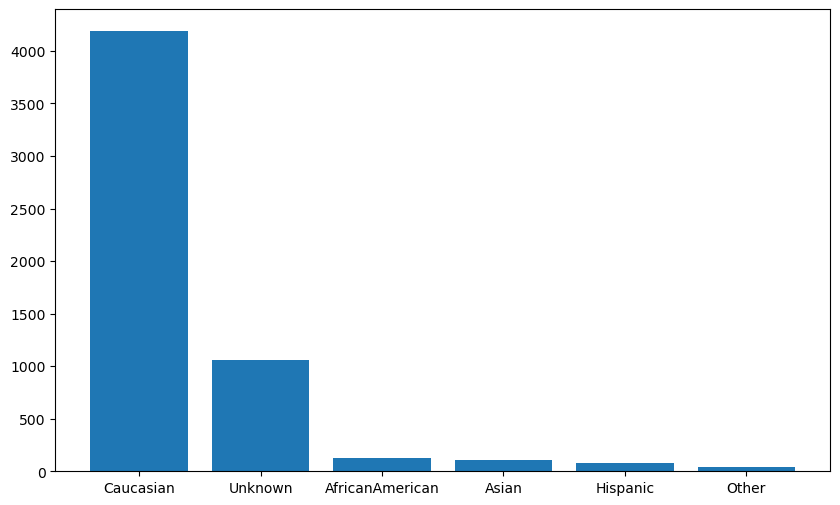

In [139]:
from matplotlib import pyplot as plt
### Distribution of sensitive attribute
plt.figure(figsize=(10, 6))
plt.bar(A_train.unique(), A_train.value_counts().values)

In [140]:
import numpy as np
import pandas as pd
from fairlearn.metrics import MetricFrame, false_positive_rate, true_positive_rate
from sklearn.metrics import precision_score, recall_score

def evaluate_fairness_one_vs_rest(model, X_test, y_test, A_test):
    """
    For each unique group in A_test, treat that group as '1'
    and the rest as '0'. Then compute:
      - TPR, FPR (for Equalized Odds)
      - Precision, Recall
      - Absolute & Non-Absolute Differences
      - Equalized Odds difference (max of TPR and FPR diffs)
    """
    # Predictions from your trained model
    y_pred = model.predict(X_test)

    # Probability predictions if needed (e.g. for TPR/FPR with thresholds)
    # y_prob = model.predict_proba(X_test)[:, 1]  # only if you need probabilities

    unique_groups = A_test.unique()
    
    # We'll store results in a list of dictionaries for neat output
    results = []
    
    for group_val in unique_groups:
        # Create a binary sensitive feature: 1 if A == group_val, else 0
        A_bin = (A_test == group_val).astype(int)

        # Build a MetricFrame for these two "groups" => 1 vs. 0
        metrics_dict = {
            "TPR": true_positive_rate,
            "FPR": false_positive_rate,
            "Precision": precision_score,
            "Recall": recall_score,
        }
        
        mf = MetricFrame(
            metrics=metrics_dict,
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=A_bin
        )

        # By-group values (we have up to 2 groups: {0, 1})
        by_group = mf.by_group  # a DataFrame with metrics for group 0 and 1

        # If for some reason the group doesn't appear in test, skip
        if len(by_group) < 2:
            # Means all test examples are from one group
            # or there's an extremely small subset. We'll skip or handle specially.
            continue

        tpr_g, tpr_r = by_group.loc[1, "TPR"], by_group.loc[0, "TPR"]
        fpr_g, fpr_r = by_group.loc[1, "FPR"], by_group.loc[0, "FPR"]
        prec_g, prec_r = by_group.loc[1, "Precision"], by_group.loc[0, "Precision"]
        rec_g, rec_r = by_group.loc[1, "Recall"], by_group.loc[0, "Recall"]

        # Non-absolute differences (group - rest)
        tpr_diff_nonabs = tpr_g - tpr_r
        fpr_diff_nonabs = fpr_g - fpr_r
        prec_diff_nonabs = prec_g - prec_r
        rec_diff_nonabs = rec_g - rec_r

        # Absolute differences
        tpr_diff_abs = abs(tpr_diff_nonabs)
        fpr_diff_abs = abs(fpr_diff_nonabs)
        prec_diff_abs = abs(prec_diff_nonabs)
        rec_diff_abs = abs(rec_diff_nonabs)
        
        # Equalized Odds difference = max of |TPR diff|, |FPR diff|
        eq_odds_diff = max(tpr_diff_abs, fpr_diff_abs)

        # Collect the results for this group
        results.append({
            "group_val": group_val,
            "group_size": (A_bin == 1).sum(),
            "TPR_group": tpr_g,
            "TPR_rest": tpr_r,
            "FPR_group": fpr_g,
            "FPR_rest": fpr_r,
            "Precision_group": prec_g,
            "Precision_rest": prec_r,
            "Recall_group": rec_g,
            "Recall_rest": rec_r,
            "TPR_diff_abs": tpr_diff_abs,
            "FPR_diff_abs": fpr_diff_abs,
            "Prec_diff_abs": prec_diff_abs,
            "Recall_diff_abs": rec_diff_abs,
            "TPR_diff_nonabs": tpr_diff_nonabs,
            "FPR_diff_nonabs": fpr_diff_nonabs,
            "Prec_diff_nonabs": prec_diff_nonabs,
            "Recall_diff_nonabs": rec_diff_nonabs,
            "Equalized_Odds_diff": eq_odds_diff
        })

    # Convert list of dicts to DataFrame for a nicer format
    results_df = pd.DataFrame(results)
    return results_df

# ==============================================
# Usage after training:
# ==============================================

# Suppose you already have:
# model (trained XGBClassifier)
# X_test, y_test
# A_test (sensitive attribute in test set)

fairness_results = evaluate_fairness_one_vs_rest(model, X_test, y_test, A_test)
print(fairness_results)


         group_val  group_size  TPR_group  TPR_rest  FPR_group  FPR_rest  \
0        Caucasian        1795        0.0       0.0        0.0       0.0   
1  AfricanAmerican         453        0.0       0.0        0.0       0.0   
2            Other          35        0.0       0.0        0.0       0.0   
3          Unknown          54        0.0       0.0        0.0       0.0   
4         Hispanic          48        0.0       0.0        0.0       0.0   
5            Asian          15        0.0       0.0        0.0       0.0   

   Precision_group  Precision_rest  Recall_group  Recall_rest  TPR_diff_abs  \
0              0.0             0.0           0.0          0.0           0.0   
1              0.0             0.0           0.0          0.0           0.0   
2              0.0             0.0           0.0          0.0           0.0   
3              0.0             0.0           0.0          0.0           0.0   
4              0.0             0.0           0.0          0.0           

/opt/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco